In [3]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pyfinancialdata
import trade_functions
import pandas_techinal_indicators

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [4]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [6]:
# A variable for the name of this notebook
notebook_name = os.path.splitext(os.path.basename(NOTEBOOK_FULL_PATH))[0]

In [7]:
price_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=range(2006, 2021),
    time_group='24h',
    price_calculation='close',
)

In [8]:
environment_columns = ['price', 'RSI_14', 'ATR_7', 'ADX_7_14']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [9]:
price_data = add_features(price_data.copy())

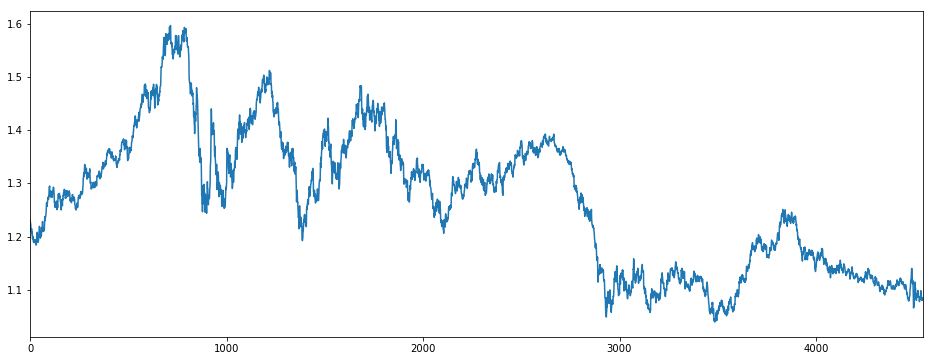

In [10]:
price_data['price'].plot(figsize=(16,6))

In [11]:
train_size = round(len(price_data)/3*2)
train_data = price_data[:train_size].copy()
train_data.reset_index(inplace=True)
test_data = price_data[train_size:].copy()
test_data.reset_index(inplace=True)
print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

train size 3031, test size 1515


In [12]:
episode=1000
batch_size=10

In [13]:
train_data.head(5)

,index,date,close,high,low,open,price,RSI_14,ATR_7,ADX_7_14
0,0,2006-01-23,1.2304,1.23220,1.21640,1.2167,1.2304,0.758386,0.009556,0.343613
1,1,2006-01-24,1.2265,1.23110,1.22572,1.2304,1.2265,0.758386,0.008510,0.365054
2,2,2006-01-25,1.2244,1.23232,1.22362,1.2264,1.2244,0.699771,0.008557,0.327176
3,3,2006-01-26,1.2213,1.22692,1.21980,1.2244,1.2213,0.602097,0.008197,0.343388
4,4,2006-01-27,1.2094,1.22352,1.20876,1.2213,1.2094,0.410861,0.009840,0.357055


In [14]:
env = SimpleTradingEnvironment(
    price_data=train_data,
    environment_columns=environment_columns,
    debug=False,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
agent = DQNAgent(state_size, action_size)
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,379
Trainable params: 1,379
Non-trainable params: 0
_________________________________________________________________
None


## Train

In [15]:
for e in range(episode):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(".", end='')
            if (e + 1) % 20 == 0:
                print("")
                print("episode: {0}/{1}".format(e + 1, episode))
                print("median profit: {0} pips, median trade count: {1}".format(
                    round(median(train_results['account_balance'].tolist()) / 0.0001),
                    round(median(train_results['trade_count'].tolist()))
                    )
                )
            train_results = train_results.append(env._stats(), ignore_index=True)
            break
        if len(agent.memory) > batch_size:
            agent.replay(batch_size)



....................
episode: 20/1000
median profit: 1305 pips, median trade count: 300
....................
episode: 40/1000
median profit: 829 pips, median trade count: 282
....................
episode: 60/1000
median profit: 1686 pips, median trade count: 290
....................
episode: 80/1000
median profit: 2457 pips, median trade count: 296
....................
episode: 100/1000
median profit: 2602 pips, median trade count: 304
....................
episode: 120/1000
median profit: 3041 pips, median trade count: 291
....................
episode: 140/1000
median profit: 3572 pips, median trade count: 291
....................
episode: 160/1000
median profit: 3995 pips, median trade count: 293
....................
episode: 180/1000
median profit: 4075 pips, median trade count: 294
....................
episode: 200/1000
median profit: 4338 pips, median trade count: 297
....................
episode: 220/1000
median profit: 4554 pips, median trade count: 297
....................
epi

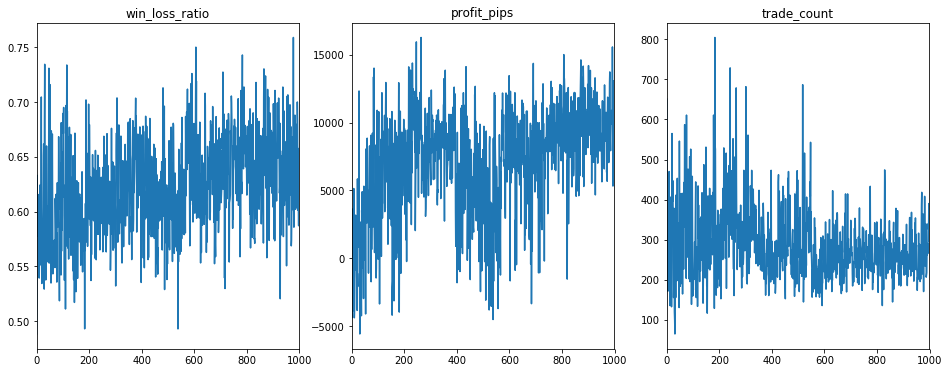

In [16]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [17]:
joblib.dump(agent, '{0}.pkl'.format(notebook_name)) 

['24h-EUR_USD.pkl']

## Test

In [18]:
# Uncomment to load agent from file 
# agent = joblib.load('{0}.pkl'.format(notebook_name))  

In [19]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data,
    environment_columns=environment_columns,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [20]:
for e in range(1000):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [21]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
test_results['account_drawdown_max_pips'] = test_results['account_drawdown_max'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))
print('Median win/loss ratio: {0}'.format(test_results['win_loss_ratio'].median()))
print('Median drawdown: {0} pips'.format(test_results['account_drawdown_max_pips'].median()))
print('Median trade count: {0}'.format(test_results['trade_count'].median()))
print('Trades per day: {0}'.format(test_results['trade_count'].median() / (test_data['date'].iloc[-1] - test_data['date'].iloc[0]).days))

Median profit: 1404.3749999999145 pips
Median win/loss ratio: 0.5503157142289822
Median drawdown: -767.5250000000077 pips
Median trade count: 166.0
Trades per day: 0.09362662154540327


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1394578d0>]],
      dtype=object)

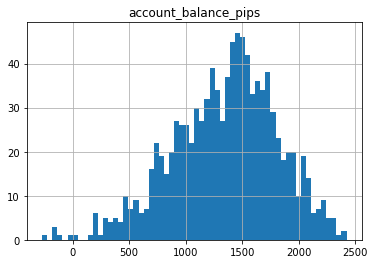

In [22]:
# Historgram of account balance
plt.figure(figsize=(16,6))
test_results.hist(column='account_balance_pips', bins=60)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13a860210>]],
      dtype=object)

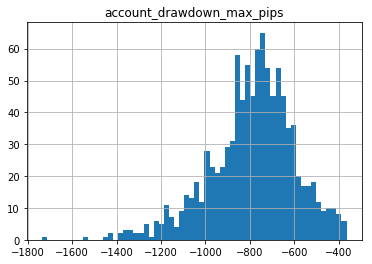

In [23]:
# Historgram of max drawdown
plt.figure(figsize=(16,6))
test_results.hist(column='account_drawdown_max_pips', bins=60)

## Analyse positions on test data

In [24]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True,
    spread=0.00015
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [25]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [26]:
env._stats()

{'trade_count': 151,
 'win_loss_ratio': 0.543046357615894,
 'account_balance': 0.21116499999999183,
 'unrealised_pl': -0.059555000000000025,
 'account_drawdown': -0.027900000000000036,
 'account_drawdown_max': -0.0364600000000006}

In [27]:
position_data = env.price_data.copy()

In [28]:
position_data['position'] = position_data['position'] - 1

In [29]:
trades = trade_functions.create_trades_from_positions(position_data.copy())

153 positions to plot...


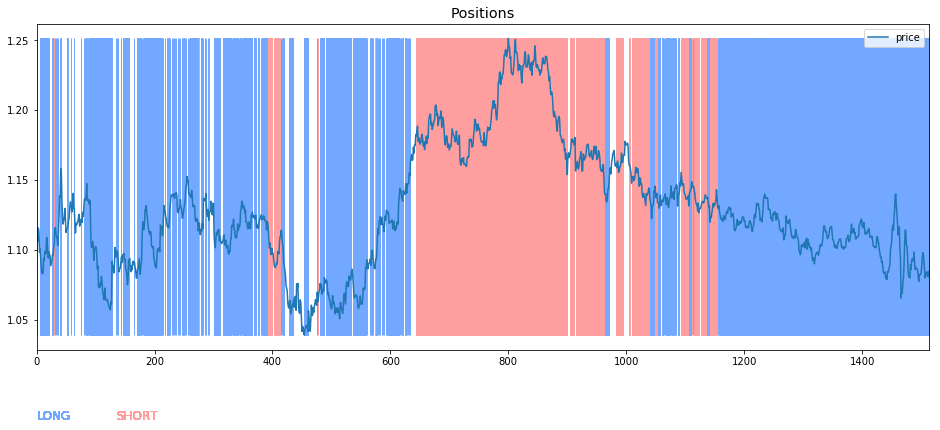

In [30]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [31]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 54.25%
Ratio of long to short positions: 4.43
Median profit: 0.0
Total profit: 0.163009999999999
Median position length: 2.0
Number of trades: 153


In [32]:
trades

,enter_date,enter_price,exit_date,exit_price,position_length,position,profit,profitable,account_balance
0,2015-07-07,1.10076,2015-07-08,1.10712,1,NaN,NaN,False,NaN
1,2015-07-13,1.09829,2015-07-28,1.10651,13,1.0,0.00822,True,0.00822
2,2015-07-29,1.09812,2015-08-02,1.09676,3,1.0,-0.00136,False,0.00686
3,2015-08-06,1.09224,2015-08-10,1.10156,3,1.0,0.00932,True,0.01618
4,2015-08-10,1.10156,2015-08-11,1.10418,1,-1.0,-0.00262,False,0.01356
...,...,...,...,...,...,...,...,...,...
148,2019-03-07,1.11981,2019-03-22,1.13014,13,-1.0,-0.01033,False,0.21597
149,2019-03-22,1.13014,2019-03-24,1.12958,1,1.0,-0.00056,False,0.21541
150,2019-03-25,1.13154,2019-06-09,1.13192,65,1.0,0.00038,True,0.21579
151,2019-06-10,1.13182,2019-06-23,1.13852,11,1.0,0.00670,True,0.22249


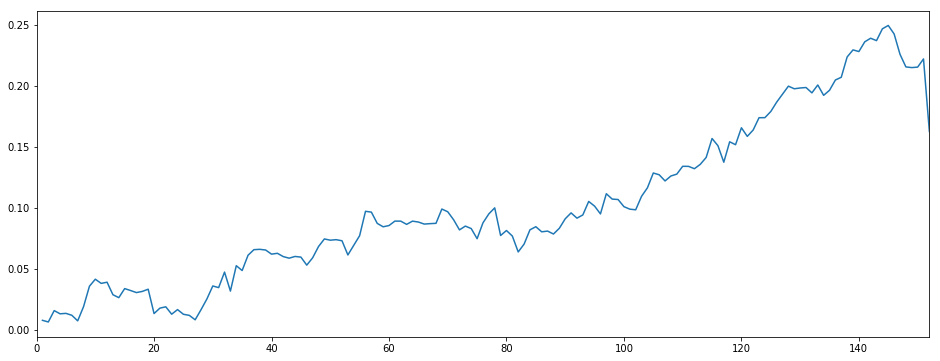

In [33]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

## Show distribution of maximum drawdown

Median drawdown: -0.08007999999999982


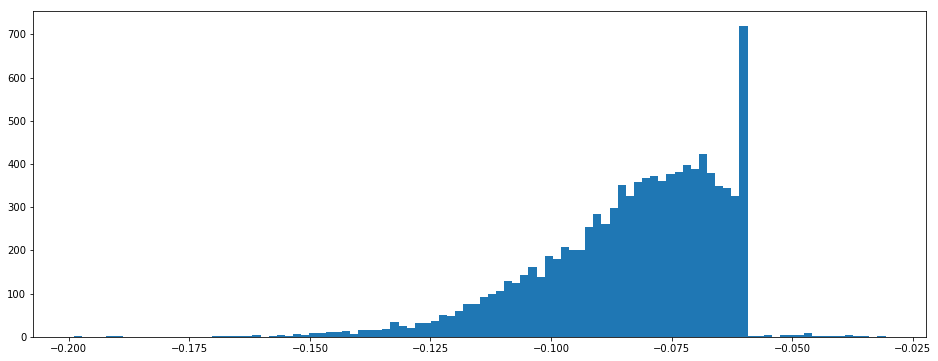

In [34]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);